## Importing libaries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import contextily as ctx

## Data Loading and Cleaning

In [2]:
# Define file path
path_csv = "nypd-motor-vehicle-collisions.csv"

# Load data with specified columns and data types
df = pd.read_csv(
    path_csv,
    usecols=[
        "BOROUGH",
        "CONTRIBUTING FACTOR VEHICLE 1",
        "CONTRIBUTING FACTOR VEHICLE 2",
        "CONTRIBUTING FACTOR VEHICLE 3",
        "CONTRIBUTING FACTOR VEHICLE 4",
        "CONTRIBUTING FACTOR VEHICLE 5",
        "NUMBER OF PERSONS INJURED",
        "NUMBER OF PERSONS KILLED",
        "NUMBER OF PEDESTRIANS INJURED",
        "NUMBER OF PEDESTRIANS KILLED",
        "NUMBER OF CYCLIST INJURED",
        "NUMBER OF CYCLIST KILLED",
        "NUMBER OF MOTORIST INJURED",
        "NUMBER OF MOTORIST KILLED",
        "COLLISION_ID",
        "VEHICLE TYPE CODE 1",
        "VEHICLE TYPE CODE 2",
        "VEHICLE TYPE CODE 3",
        "VEHICLE TYPE CODE 4",
        "VEHICLE TYPE CODE 5",
        "LATITUDE",
        "LONGITUDE",
        "LOCATION"
    ],
    dtype={
        "BOROUGH": "object",
        "CONTRIBUTING FACTOR VEHICLE 1": "object",
        "CONTRIBUTING FACTOR VEHICLE 2": "object",
        "CONTRIBUTING FACTOR VEHICLE 3": "object",
        "CONTRIBUTING FACTOR VEHICLE 4": "object",
        "CONTRIBUTING FACTOR VEHICLE 5": "object",
        "NUMBER OF PERSONS INJURED": "float64",
        "NUMBER OF PERSONS KILLED": "float64",
        "NUMBER OF PEDESTRIANS INJURED": "float64",
        "NUMBER OF PEDESTRIANS KILLED": "float64",
        "NUMBER OF CYCLIST INJURED": "float64",
        "NUMBER OF CYCLIST KILLED": "float64",
        "NUMBER OF MOTORIST INJURED": "float64",
        "NUMBER OF MOTORIST KILLED": "float64",
        "COLLISION_ID": "int64",
        "VEHICLE TYPE CODE 1": "object",
        "VEHICLE TYPE CODE 2": "object",
        "VEHICLE TYPE CODE 3": "object",
        "VEHICLE TYPE CODE 4": "object",
        "VEHICLE TYPE CODE 5": "object",
        "LATITUDE": "float64",
        "LONGITUDE": "float64",
        "LOCATION": "object"
    }
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612178 entries, 0 to 1612177
Data columns (total 23 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   BOROUGH                        1127553 non-null  object 
 1   LATITUDE                       1415893 non-null  float64
 2   LONGITUDE                      1415893 non-null  float64
 3   LOCATION                       1415893 non-null  object 
 4   NUMBER OF PERSONS INJURED      1612161 non-null  float64
 5   NUMBER OF PERSONS KILLED       1612145 non-null  float64
 6   NUMBER OF PEDESTRIANS INJURED  1612178 non-null  float64
 7   NUMBER OF PEDESTRIANS KILLED   1612178 non-null  float64
 8   NUMBER OF CYCLIST INJURED      1612178 non-null  float64
 9   NUMBER OF CYCLIST KILLED       1612178 non-null  float64
 10  NUMBER OF MOTORIST INJURED     1612178 non-null  float64
 11  NUMBER OF MOTORIST KILLED      1612178 non-null  float64
 12  CONTRIBUTING F

### Check percentage of missing boroughs

In [3]:
nan_boroughs = df[df['BOROUGH'].isna()]
percent_empty_boroughs = len(nan_boroughs) / len(df) * 100

print(f"Total rows: {len(df)}")
print(f"Rows with empty boroughs: {len(nan_boroughs)}")
print(f"Percentage of rows with empty boroughs: {percent_empty_boroughs:.2f}%")

Total rows: 1612178
Rows with empty boroughs: 484625
Percentage of rows with empty boroughs: 30.06%


### Drop rows with missing borough information

In [4]:
df = df.dropna(subset=['BOROUGH'])

### Convert string columns to uppercase

In [5]:
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').apply(lambda x: x.str.upper())

df.head(3)

,BOROUGH,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,QUEENS,40.676052,-73.790184,"{'TYPE': 'POINT', 'COORDINATES': [-73.790184, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,UNSPECIFIED,NaN,NaN,NaN,4184637,SEDAN,PICK-UP TRUCK,NaN,NaN,NaN
1,BROOKLYN,40.657780,-73.951096,"{'TYPE': 'POINT', 'COORDINATES': [-73.951096, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,UNSPECIFIED,NaN,NaN,NaN,4195773,STATION WAGON/SPORT UTILITY VEHICLE,STATION WAGON/SPORT UTILITY VEHICLE,NaN,NaN,NaN
2,MANHATTAN,40.718143,-73.993835,"{'TYPE': 'POINT', 'COORDINATES': [-73.993835, ...",1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,4202457,SEDAN,NaN,NaN,NaN,NaN


### Checking if there are duplicate colision IDs

In [6]:
df_copy = df.copy()
df = df.drop_duplicates(subset='COLLISION_ID')


print(f"unique IDs:{len(df)}")
print(f"all IDs:{len(df_copy)}")
print(f"duplicate IDs:{len(df_copy)-len(df)}")

unique IDs:847386
all IDs:1127553
duplicate IDs:280167


### Dropping duplicate collision IDs

In [7]:
df = df.drop_duplicates(subset='COLLISION_ID')

### Create aggregated columns for total injuries and fatalities

In [9]:
df['TOTAL_KILLED'] = (
    df['NUMBER OF PERSONS KILLED'] +
    df['NUMBER OF PEDESTRIANS KILLED'] +
    df['NUMBER OF CYCLIST KILLED'] +
    df['NUMBER OF MOTORIST KILLED']
)

df['TOTAL_INJURED'] = (
    df['NUMBER OF PERSONS INJURED'] +
    df['NUMBER OF PEDESTRIANS INJURED'] +
    df['NUMBER OF CYCLIST INJURED'] +
    df['NUMBER OF MOTORIST INJURED']
)

In [14]:
### Calculate total killed/injured

In [15]:
df['TOTAL_KILLED/INJURED'] = df['TOTAL_KILLED'] + df['TOTAL_INJURED']

### Combine contributing factor columns

In [10]:
df = df.melt(
    id_vars=['BOROUGH', 'TOTAL_KILLED', 'TOTAL_INJURED'],
    value_vars=[
        'CONTRIBUTING FACTOR VEHICLE 1',
        'CONTRIBUTING FACTOR VEHICLE 2',
        'CONTRIBUTING FACTOR VEHICLE 3',
        'CONTRIBUTING FACTOR VEHICLE 4',
        'CONTRIBUTING FACTOR VEHICLE 5'
    ],
    var_name='vehicle_number',
    value_name='accident_cause'
)

### Remove rows with missing accident causes

In [11]:
df = df.dropna(subset=['accident_cause'])

### checking what causes we have in our dataframe

In [12]:
Accident_Cause_list = df['accident_cause'].unique().tolist()


Accident_Cause_list

['PASSING TOO CLOSELY',
 'DRIVER INATTENTION/DISTRACTION',
 'UNSPECIFIED',
 'REACTION TO UNINVOLVED VEHICLE',
 'FOLLOWING TOO CLOSELY',
 'PASSING OR LANE USAGE IMPROPER',
 'VIEW OBSTRUCTED/LIMITED',
 'AGGRESSIVE DRIVING/ROAD RAGE',
 'OTHER VEHICULAR',
 'DRIVERLESS/RUNAWAY VEHICLE',
 'TURNING IMPROPERLY',
 'FAILURE TO YIELD RIGHT-OF-WAY',
 'BACKING UNSAFELY',
 'BRAKES DEFECTIVE',
 'UNSAFE LANE CHANGING',
 'PAVEMENT DEFECTIVE',
 'TRAFFIC CONTROL DISREGARDED',
 'TIRE FAILURE/INADEQUATE',
 'OBSTRUCTION/DEBRIS',
 'UNSAFE SPEED',
 'ALCOHOL INVOLVEMENT',
 'DRIVER INEXPERIENCE',
 'PAVEMENT SLIPPERY',
 'PEDESTRIAN/BICYCLIST/OTHER PEDESTRIAN ERROR/CONFUSION',
 'PASSENGER DISTRACTION',
 'OVERSIZED VEHICLE',
 'FAILURE TO KEEP RIGHT',
 'STEERING FAILURE',
 'GLARE',
 'OUTSIDE CAR DISTRACTION',
 'DRUGS (ILLEGAL)',
 'FELL ASLEEP',
 'PHYSICAL DISABILITY',
 'ILLNES',
 'ANIMALS ACTION',
 'FATIGUED/DROWSY',
 'OTHER LIGHTING DEFECTS',
 'LOST CONSCIOUSNESS',
 'ACCELERATOR DEFECTIVE',
 'TOW HITCH DEFECTIVE',

### Remove unwanted accident causes

In [13]:
causes_to_remove = ['UNSPECIFIED', 'OTHER VEHICULAR', '80', '1']
df = df[~df['accident_cause'].isin(causes_to_remove)]

## Data Analysis

### 1. Top 3 dangerous accident causes per borough

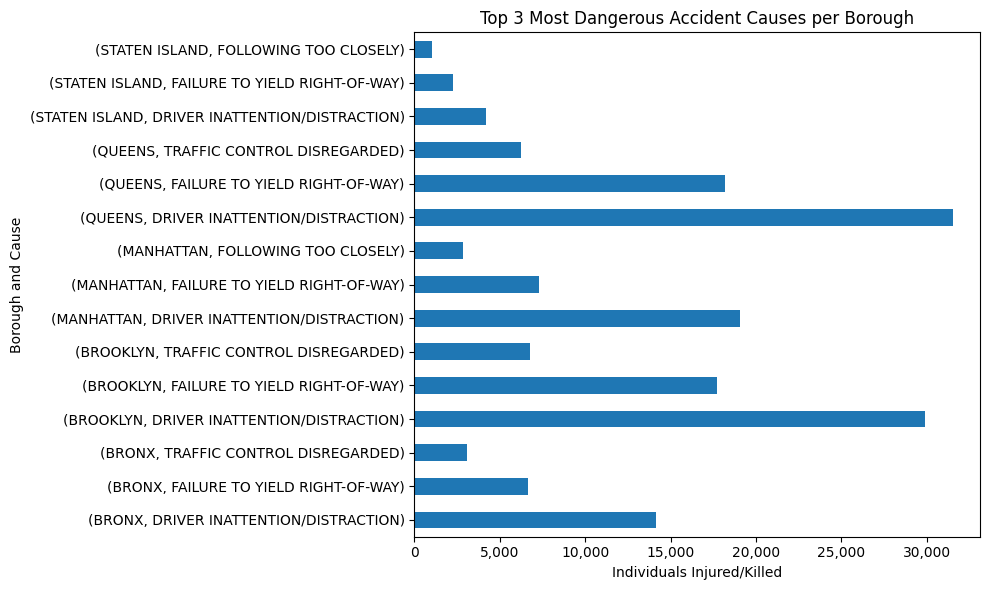

In [22]:
first_analysis = (
    df.groupby(['BOROUGH', 'accident_cause'])['TOTAL_KILLED/INJURED']
    .sum()
    .groupby(level=0, group_keys=False)
    .nlargest(3)
    .reset_index()
)

first_analysis.set_index(['BOROUGH', 'accident_cause'])['TOTAL_KILLED/INJURED'].plot(kind='barh', figsize=(10, 6))
plt.xlabel('Individuals Injured/Killed')
plt.ylabel('Borough and Cause')
plt.title('Top 3 Most Dangerous Accident Causes per Borough')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

### 2. Speeding-related accidents per borough

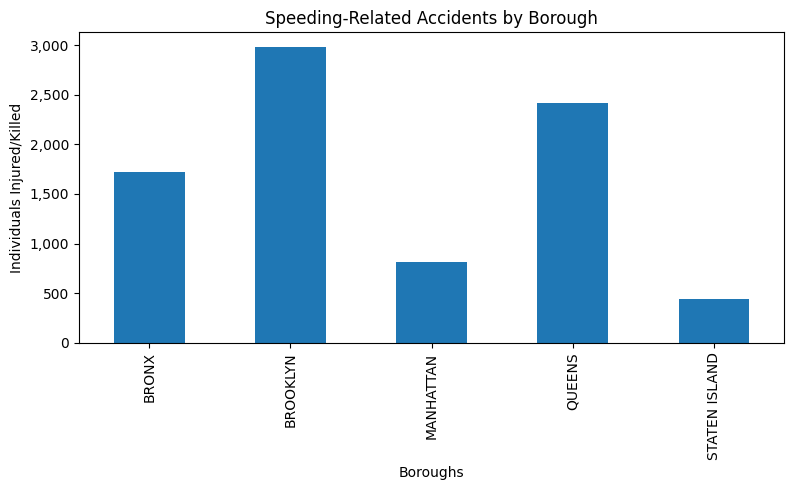

In [24]:
speeding_cases = df[df['accident_cause'] == "UNSAFE SPEED"]
speeding_analysis = speeding_cases.groupby('BOROUGH')['TOTAL_KILLED/INJURED'].sum()
speeding_analysis.plot(kind='bar', figsize=(8, 5))
plt.xlabel('Boroughs')
plt.ylabel('Individuals Injured/Killed')
plt.title('Speeding-Related Accidents by Borough')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

### 3,1 . Top 3 most common accident causes per boroughs

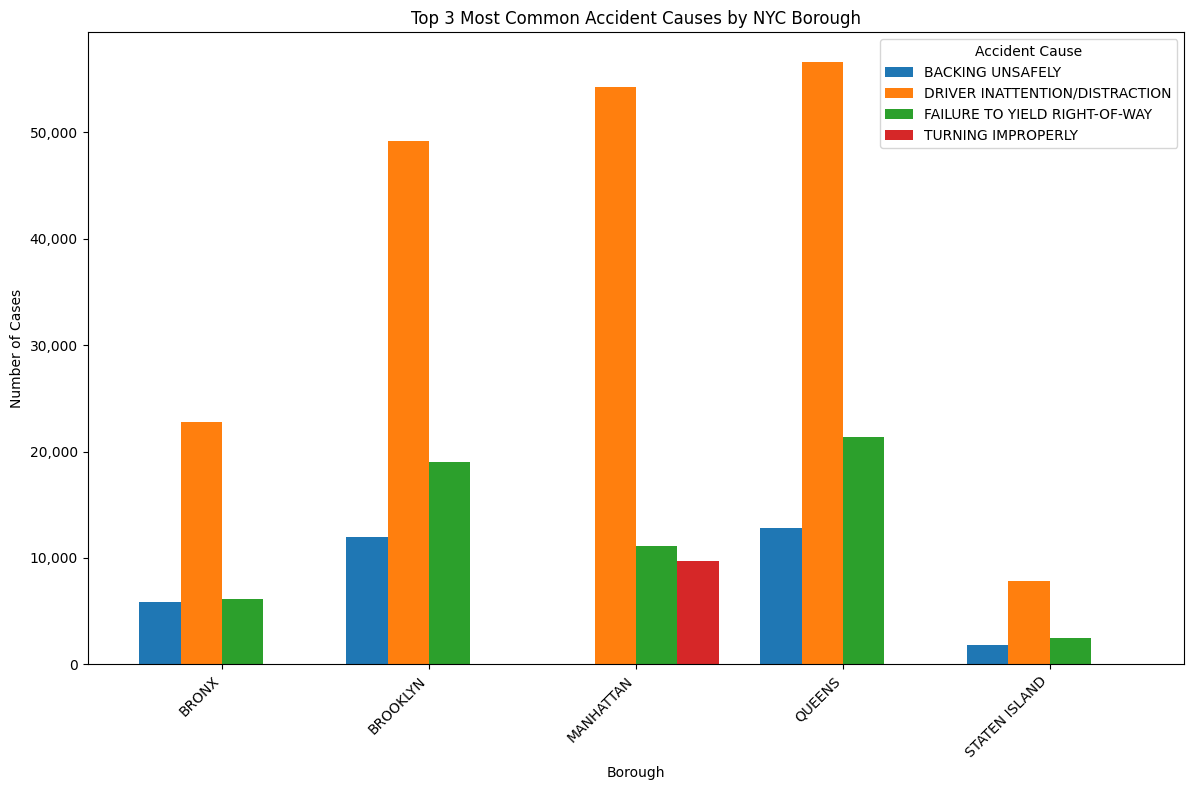

In [26]:
accident_causes_per_boroughs = (
    df.groupby(['BOROUGH', 'accident_cause'])
    .size()  # Count occurrences of each cause per borough
    .reset_index(name='TOTAL_COUNT')  # Rename the count column
)

# Keeping only the top 3 causes per borough
accident_causes_per_boroughs = (
    accident_causes_per_boroughs.sort_values(['BOROUGH', 'TOTAL_COUNT'], ascending=[True, False])
    .groupby('BOROUGH')
    .head(3) 
)

# Pivoting the data for clustered bar chart
pivot_data = accident_causes_per_boroughs.pivot(index='BOROUGH', columns='accident_cause', values='TOTAL_COUNT').fillna(0)

# Creating the  bar chart
ax = pivot_data.plot(kind='bar', figsize=(12, 8), width=0.8)

# Customizing the bar chart
plt.xlabel('Borough')
plt.ylabel('Number of Cases')
plt.title('Top 3 Most Common Accident Causes by NYC Borough')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accident Cause')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
# Displaying the bar chart
plt.show()

### 3,2 . Top 3 most common accident causes per overall

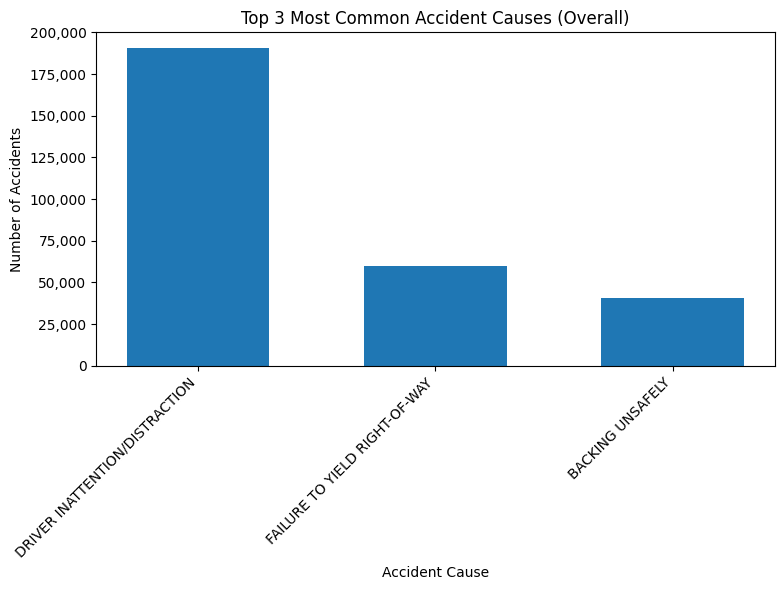

In [28]:
#Grouping by accident_cause to calculate the total count across the entire city
accident_causes_overall = (
    df.groupby('accident_cause')
    .size()  # Count occurrences of each cause
    .reset_index(name='TOTAL_COUNT')  # Rename the count column
)

# Keeping only the top 3 causes
accident_causes_overall = accident_causes_overall.sort_values('TOTAL_COUNT', ascending=False).head(3)

# Creating the bar chart
plt.figure(figsize=(8, 6))
plt.bar(Third_Analysis_v2['accident_cause'], accident_causes_overall['TOTAL_COUNT'], width=0.6)

# Customizing the chart
plt.xlabel('Accident Cause')
plt.ylabel('Number of Accidents')
plt.title('Top 3 Most Common Accident Causes (Overall)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
# Display the plot
plt.show()


### 4. Visualize NYC accident locations 

In [21]:
area = ox.geocode_to_gdf("New York City, NY")
df['long_lat_point'] = df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
points_gdf = gpd.GeoSeries(df['long_lat_point'], crs="EPSG:4326")
ax = area.plot(figsize=(10, 10), facecolor='none', edgecolor='black')
points_gdf.sample(1000).plot(ax=ax, marker='o', color='red', markersize=5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=area.crs)
plt.title('NYC Motor Vehicle Collision Locations')
plt.show()

KeyError: 'LONGITUDE'